In [1]:
import pandas as pd

testing_df = pd.read_csv('data/testing/testing_dataset.csv')
testing_df.columns

Index(['text', 'Sentiment_Text'], dtype='object')

In [2]:
import torch
from transformers import XLMRobertaTokenizer
from preprocessing import Preprocessing
from model_3 import SemanticClassifier

labels = ["Negative", "Neutral", "Positive"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preprocessing_instance = Preprocessing()

state_dict = torch.load(
    "data/semantic_classifier_3_dict.pth", map_location=device
)
model = SemanticClassifier()
model.load_state_dict(state_dict)
model.to(device)
model.eval()

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")


def preprocess_text(text, max_length=256, device="cuda"):
    processed_text = preprocessing_instance.preprocessing_pipeline_roberta(text)
    processed_text = str(processed_text)
    encoding = tokenizer(
        processed_text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

    return {
        "input_ids": encoding["input_ids"].to(device),
        "attention_mask": encoding["attention_mask"].to(device),
    }


def predict(text):
    inputs = preprocess_text(text, device=device)

    with torch.no_grad():
        output = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])

    predicted_label = torch.argmax(output, dim=1).cpu().item()
    return labels[int(predicted_label)]

testing_df["Predicted_Sentiment_Text"] = testing_df["text"].apply(predict)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\malaya\tokenizer.py:214: FutureWarning: Possible nested set at position 3397
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\malaya\tokenizer.py:214: FutureWarning: Possible nested set at position 3927
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
c:\Users\USER\Study\Y2S2\AI\ManglishSentimentAnalysis\preprocessing.py:14: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download

In [3]:
label_dict = {
    0:'Negative',
    1:'Neutral',
    2:'Positive'
}

testing_df['Sentiment_Text'] = testing_df['Sentiment_Text'].apply(lambda x: label_dict[x])

In [4]:
testing_df.head()

,text,Sentiment_Text,Predicted_Sentiment_Text
0,"Walao, this shop damn expensive lah!",Negative,Neutral
1,"Bro, jom go makan nasi lemak at that place!",Neutral,Neutral
2,"Aiyo, why you so blur one?",Negative,Neutral
3,"This movie damn syok, must watch!",Positive,Negative
4,Can borrow me your charger ah?,Neutral,Negative


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = testing_df['Sentiment_Text']
y_pred = testing_df['Predicted_Sentiment_Text']

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[12 12  0]
 [ 3 12  2]
 [ 6  4 18]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.57      0.50      0.53        24
     Neutral       0.43      0.71      0.53        17
    Positive       0.90      0.64      0.75        28

    accuracy                           0.61        69
   macro avg       0.63      0.62      0.61        69
weighted avg       0.67      0.61      0.62        69



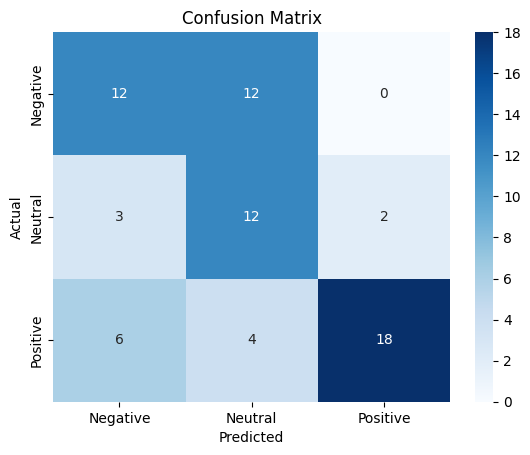

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

labels = sorted(testing_df['Sentiment_Text'].unique()) 

sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), 
            annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()